This notebook aims to act as as a self contained test of the rotation suite. It runs off pc494/pycrystem master branch. Some stuff has been bundled together to make it a shorter document.

In [1]:
%matplotlib tk
import numpy as np
import hyperspy.api as hs
import pycrystem as pc
import pymatgen as pmg
from matplotlib import pyplot as plt
from pymatgen.transformations.standard_transformations import RotationTransformation
from pycrystem.indexation_generator import IndexationGenerator
from pycrystem.utils.expt_utils import radial_average
from scipy.constants import pi

<center><h1> I - Create the "Experimental" Patterns </h1></center>

In [2]:
si = pmg.Element("Si")
lattice = pmg.Lattice.cubic(5.431)
silicon = pmg.Structure.from_spacegroup("Fd-3m",lattice, [si], [[0, 0, 0]])

In [3]:
size = 256
radius=1.5
ediff = pc.ElectronDiffractionCalculator(300., 0.025)

rotaxis,thetas = [0, 0, 1],np.arange(0, 20, 1)
data_silicon = []
for theta in thetas:
    sieg = RotationTransformation(rotaxis, theta).apply_transformation(silicon)
    dpi = ediff.calculate_ed_data(sieg, radius).as_signal(256, 0.03, 1.2)
    data_silicon.append(dpi.data)
    
data = [data_silicon]*20
test_data = pc.ElectronDiffraction(data)
test_data.set_calibration(1.2/128)

In [4]:
test_data.plot()

<center><h1> II - Create the template Library </h1></center>

In [5]:
rot_list = []
nstep=119
#np.linspace(0)
for i in np.arange(nstep):
    theta = (i*59.5/(nstep-1))/180*pi
    rot_list.append((theta, 0., 0.))

In [6]:
edc = pc.ElectronDiffractionCalculator(300, 0.025)
diff_gen = pc.DiffractionLibraryGenerator(edc)
struc_lib = dict()
struc_lib['si'] = (silicon, rot_list)
library = diff_gen.get_diffraction_library(struc_lib,
                                            calibration=1.2/128,
                                            reciprocal_radius=1.5,
                                            representation='euler')

<center><h3> And the (slowest) correct answer </h3></center>

In [7]:
### Ground Truth
indexer = IndexationGenerator(test_data, library)
match_results = indexer.correlate()

A Jupyter Widget

400/|/100%|| 400/400 [00:30<00:00, 26.48it/s]

In [8]:
match_results

<MatchingResults, title: , dimensions: (20, 20|5, 5)>

In [9]:
match_results.plot() # this is fun, signal is <phase,x,z,x,correlation>

In [10]:
plt.close("all")

In [11]:
def _convert_to_2D(peak_locations):
    #if np.any(peak_locations[:,2] > 5e-2):
    #    print("This will be a warning in future, but be aware that you may not be within a 2D regime")
    peak_locations = peak_locations[:,0:2]
    return peak_locations

_phase = 'si'

def function_version_1(single):
    best_fit = single[0][1:4]
    best_fit_pattern = library[_phase][(best_fit[0],best_fit[1],best_fit[2])]
    peak_locations = best_fit_pattern.coordinates
    peak_locations = _convert_to_2D(best_fit_pattern.coordinates)
    return peak_locations

found_peaks = match_results.map(function_version_1,inplace=False,show_progressbar=False)
from pycrystem.diffraction_vectors import DiffractionVectors
found_peaks = DiffractionVectors(found_peaks)
found_peaks.axes_manager.set_signal_dimension(0)
found_peaks = found_peaks.transpose(navigation_axes=2)

In [12]:
found_peaks

<Signal2D, title: , dimensions: (20, 20|2, 24)>

In [13]:
test_data

<ElectronDiffraction, title: , dimensions: (20, 20|256, 256)>

In [14]:
from pycrystem.utils import plot as pcplt
mmx,mmy = pcplt.generate_marker_inputs_from_peaks(found_peaks)

In [15]:
test_data = pc.ElectronDiffraction(data)
test_data.set_calibration(1.2/128)
test_data.plot(cmap='viridis') 
for mx,my in zip(mmx,mmy):
    m = hs.markers.point(x=my.T,y=mx.T,color='red',marker='x')
    test_data.add_marker(m,plot_marker=True,permanent=True)

In [31]:
from pycrystem.utils.plot import _find_max_length_peaks
def generate_marker_inputs_from_peaks(peaks):
    max_peak_len = _find_max_length_peaks(peaks)
    #TODO - Fix for a single image
    import itertools
    pad = np.array(list(itertools.zip_longest(*np.concatenate(peaks.data),fillvalue=[np.nan,np.nan])))
    # Not tested for non-square signal, return flat to square
    
    pad = pad.reshape((max_peak_len),peaks.data.shape[0],peaks.data.shape[1],2)
    xy_cords = np.transpose(pad,[3,0,1,2]) #move the x,y pairs to the front 
    x = xy_cords[0]
    y = xy_cords[1]

    return x,y

In [32]:
mmx,mmy = generate_marker_inputs_from_peaks(found_peaks)
test_data = pc.ElectronDiffraction(data)
test_data.set_calibration(1.2/128)
test_data.plot(cmap='viridis') 
for mx,my in zip(mmx,mmy):
    m = hs.markers.point(x=mx,y=my,color='red',marker='x')
    test_data.add_marker(m,plot_marker=True,permanent=True)

In [21]:
plt.close("all")

<center><h3> Now the magic attempt begins </center></h3>

In [84]:
radial_sims = {}
for XZX in [(0.0,0.00,0.00),rot_list[50]]:
    peaks_2D_data = library['si'][XZX].as_signal(256,0.07,1.2).data #basically a local
    radial_sims[XZX] = radial_average(peaks_2D_data,center=[256/2,256/2],cython=False)

In [85]:
radial_averaged_data = test_data.map(radial_average,center=np.asarray([256/2,256/2]),cython=False,inplace=False, show_progressbar=False)

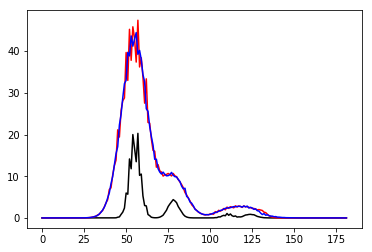

In [86]:
for XZX in radial_sims:
    #plt.plot(radial_sims[XZX])
    break
%matplotlib inline    
plt.plot(radial_averaged_data.inav[0,0],color='k')
plt.plot(radial_sims[(0.0,0.00,0.00)],color='r')
plt.plot(radial_sims[rot_list[50]],color='b')

In [87]:
print(np.sum(np.multiply(radial_averaged_data.inav[0,0].data,radial_sims[(0.0,0.00,0.00)])))
print(np.sum(np.multiply(radial_averaged_data.inav[0,0].data,radial_sims[rot_list[50]])))

6286.13503892
6138.10205838


Conclusion, peak only radial matching gives the wrong answers at present. However over/under smearing aids us

<center><h3> Under development </h3></center>

In [12]:
def mapable_library_matcher(dp_radial,dict_of_radial_patterns,n_scorer=5):
    best_corr = [0]*n_scorer 
    best_corr_key = [None]*n_scorer
    from pycrystem.utils import _correlate
    for key in dict_of_radial_patterns:
        radial_pattern_rotate = dict_of_radial_patterns[key]
        correlation = _correlate(dp_radial,radial_pattern_rotate)
        if correlation > np.min(best_corr):
            best_corr[np.argmin(best_corr)] = correlation
            best_corr_key[np.argmin(best_corr)] = key
            
    return best_corr,best_corr_key

In [13]:
alpha = radial_averaged_data.map(mapable_library_matcher,dict_of_radial_patterns=radial_sims,n_scorer=2,inplace=False)

A Jupyter Widget

In [14]:
alpha.inav[0]

([0.76828670512207153, 0.76824999083863821],
 [(0.18481261867516227, 0.0, 0.0), (0.299220430235977, 0.0, 0.0)])